# Training Notebook for the Time Windows Approach

### Import Dependencies

In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import os
from utils import *

model_output_path = 'models'
os.makedirs(model_output_path, exist_ok=True)

In [2]:
#set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
pl.seed_everything(42)
torch.backends.cudnn.deterministic = True

Seed set to 42


### Dataset & Dataloader Definition

In [3]:
df_filtered = pd.read_csv("original_training_set_filtered.csv")
df_train = pd.read_csv("splits/train.csv")
df_val = pd.read_csv("splits/val.csv")
df_test = pd.read_csv("splits/test.csv")

# Preprocessing
feature_columns = [col for col in df_train.columns if col not in ["label", "exp_name"]]
scaler = StandardScaler()
scaler.fit(df_train[feature_columns])
mean = scaler.mean_
std = scaler.scale_

# Label encoding
exp_labels = df_filtered.groupby("exp_name")["label"].first()
label_encoder = LabelEncoder()
label_encoder.fit(exp_labels.values)
exp_name_to_label = exp_labels.to_dict()

# Dataset creation with overlap
N = 100

train_dataset = SensorDataset(df_train, exp_name_to_label, label_encoder, mean, std, N=N)
val_dataset   = SensorDataset(df_val,   exp_name_to_label, label_encoder, mean, std, N=N)
test_dataset  = SensorDataset(df_test,  exp_name_to_label, label_encoder, mean, std, N=N)

In [4]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 348310
Validation dataset size: 43122
Test dataset size: 40695


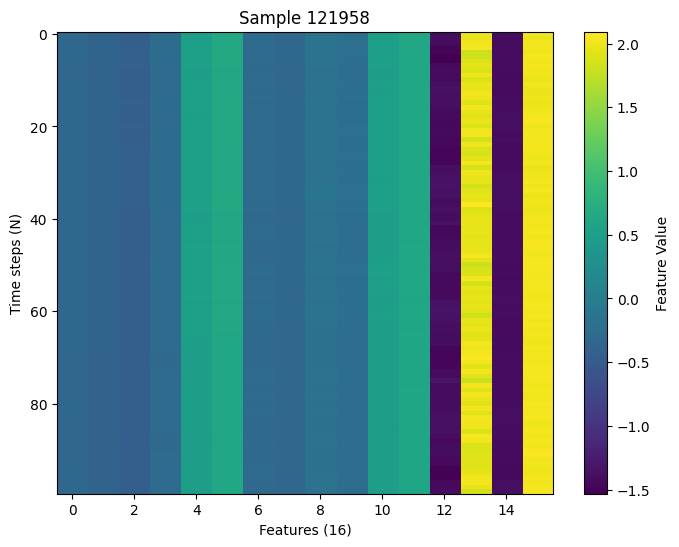

In [5]:
train_dataset.plot_sample()  # Plot the first sample from the training dataset

In [6]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Model Training

#### Column Selective Encoder + MLP

##### m = 5, k = 3

In [7]:
hidden_dim = 64
m = 5  # number of column-specific nodes per feature
k = 3  # number of fully connected nodes
model = CSEncoderMLPClassifier(
    num_features=len(feature_columns),
    window_size=N,
    m=m,
    k=k,
    hidden_dim=hidden_dim,
    num_classes=len(label_encoder.classes_),
    lr=1e-4,
    dropout=0.2,
    weight_decay=1e-5
)

In [8]:
MAX_EPOCHS = 50

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=MAX_EPOCHS // 10,
    verbose=False,
    mode="min"
)


trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[early_stop_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1
)

trainer.fit(model, train_loader, val_loader)
# Save the model
output_name = f"CSEMLP_h{hidden_dim}_m{m}_k{k}_{now_date()}.ckpt"
trainer.save_checkpoint(os.path.join(model_output_path, output_name))

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                    | Params | Mode 
------------------------------------------------------------
0 | encoder | ColumnSelectiveEncoding 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 8: 100%|██████████| 10884/10884 [10:37<00:00, 17.08it/s, v_num=0, train_loss=0.912, train_acc=0.688, val_loss=1.180, val_acc=0.636]


In [9]:
# Load the model for testing (from checkpoint)
model = CSEncoderMLPClassifier.load_from_checkpoint(os.path.join(model_output_path, output_name))
model.eval()
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1272/1272 [00:50<00:00, 25.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5169922709465027
        test_loss           1.7427904605865479
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.7427904605865479, 'test_acc': 0.5169922709465027}]

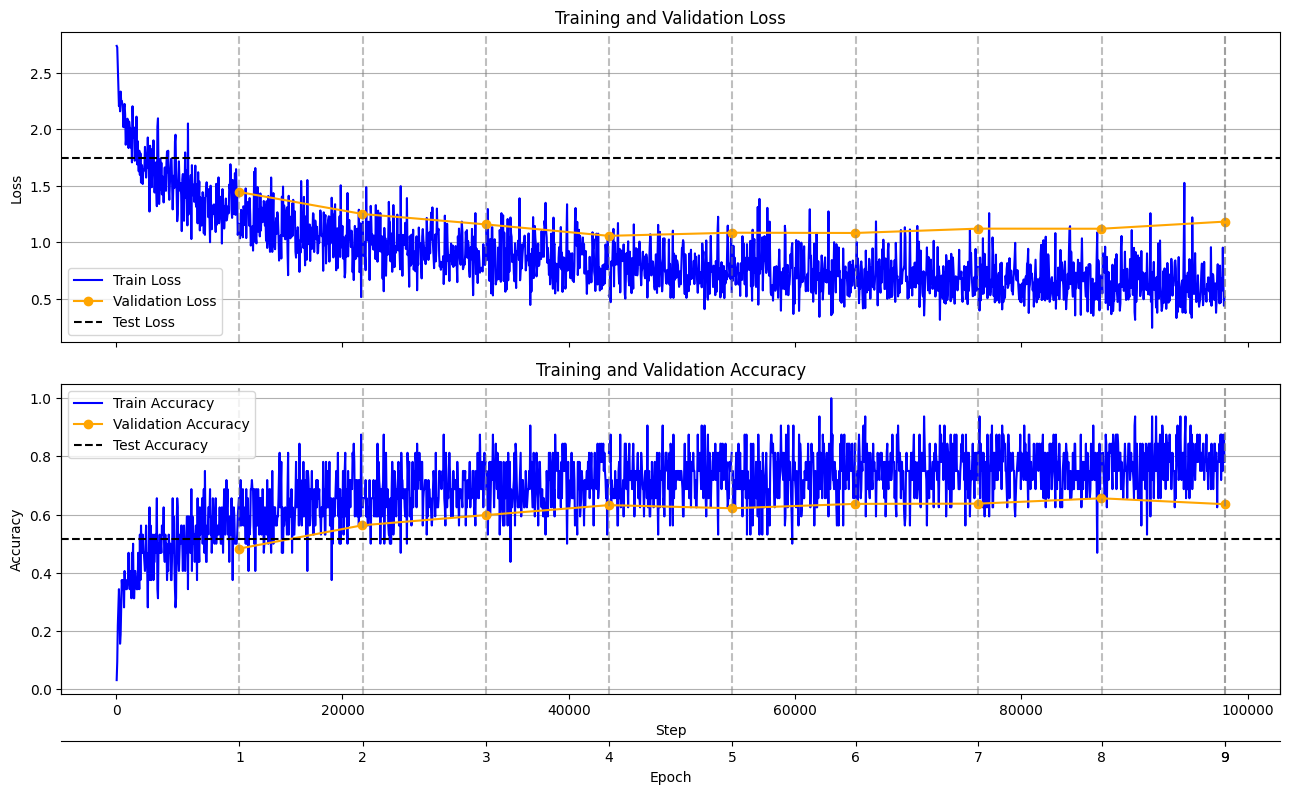

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv("lightning_logs/version_0/metrics.csv")

# Convert columns to numeric safely
df["val_loss"] = pd.to_numeric(df["val_loss"], errors='coerce')
df["val_acc"] = pd.to_numeric(df["val_acc"], errors='coerce')
df["train_loss"] = pd.to_numeric(df["train_loss"], errors='coerce')
df["train_acc"] = pd.to_numeric(df["train_acc"], errors='coerce')

# Determine where epochs end
epoch_ends = df[df["epoch"].diff().fillna(0) > 0].index.tolist()
epoch_ends.append(len(df) - 1)  # Include last row as final step

# Epoch ticks and step positions
epoch_ticks = df.loc[epoch_ends, "step"].tolist()
epoch_labels = df.loc[epoch_ends, "epoch"].astype(int).tolist()

# Optional test metrics
test_loss = df["test_loss"].dropna().iloc[-1] if "test_loss" in df.columns else None
test_acc = df["test_acc"].dropna().iloc[-1] if "test_acc" in df.columns else None

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

# Plot losses
ax1.plot(df["step"], df["train_loss"], label="Train Loss", color="blue")
ax1.plot(df["step"][df["val_loss"].notna()], df["val_loss"].dropna(), label="Validation Loss", color="orange", marker="o")

for idx in epoch_ends:
    ax1.axvline(x=df.loc[idx, "step"], color='gray', linestyle='--', alpha=0.5)

if test_loss is not None:
    ax1.axhline(y=test_loss, color='black', linestyle='--', label="Test Loss")

ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()
ax1.grid(axis='y')  # Only horizontal grid

# Plot accuracy
ax2.plot(df["step"], df["train_acc"], label="Train Accuracy", color="blue")
ax2.plot(df["step"][df["val_acc"].notna()], df["val_acc"].dropna(), label="Validation Accuracy", color="orange", marker="o")

for idx in epoch_ends:
    ax2.axvline(x=df.loc[idx, "step"], color='gray', linestyle='--', alpha=0.5)

if test_acc is not None:
    ax2.axhline(y=test_acc, color='black', linestyle='--', label="Test Accuracy")

ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Step")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
ax2.grid(axis='y')  # Only horizontal grid

# Add secondary x-axis for epochs (at bottom)
ax2_epoch = ax2.twiny()
ax2_epoch.set_frame_on(True)
ax2_epoch.patch.set_visible(False)
ax2_epoch.xaxis.set_ticks_position("bottom")
ax2_epoch.xaxis.set_label_position("bottom")
ax2_epoch.spines["bottom"].set_position(("axes", -0.15))
ax2_epoch.spines["top"].set_visible(False)
ax2_epoch.set_xlim(ax2.get_xlim())
ax2_epoch.set_xticks(epoch_ticks)
ax2_epoch.set_xticklabels(epoch_labels)
ax2_epoch.set_xlabel("Epoch")

plt.tight_layout()
plt.show()


##### m = 1, k = 3

In [11]:
hidden_dim = 64
m = 1  # number of column-specific nodes per feature
k = 3  # number of fully connected nodes
model = CSEncoderMLPClassifier(
    num_features=len(feature_columns),
    window_size=N,
    m=m,
    k=k,
    hidden_dim=hidden_dim,
    num_classes=len(label_encoder.classes_),
    lr=1e-4,
    dropout=0.2,
    weight_decay=1e-5
)

In [12]:
MAX_EPOCHS = 50

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=MAX_EPOCHS // 10,
    verbose=False,
    mode="min"
)


trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[early_stop_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1
)

trainer.fit(model, train_loader, val_loader)
# Save the model
output_name = f"CSEMLP_h{hidden_dim}_m{m}_k{k}_{now_date()}.ckpt"
trainer.save_checkpoint(os.path.join(model_output_path, output_name))

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                    | Params | Mode 
------------------------------------------------------------
0 | encoder | ColumnSelectiveEncoding | 6.4 K  | train
1 | mlp     | Sequential              | 2.4 K  | train
2 | loss_fn | CrossEntropyLoss        | 0      | train
------------------------------------------------------------
8.8 K     Trainable params
0         Non-trainable params
8.8 K     Total params
0.035     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 8: 100%|██████████| 10884/10884 [10:42<00:00, 16.93it/s, v_num=1, train_loss=0.793, train_acc=0.750, val_loss=1.280, val_acc=0.606]


In [13]:
# Load the model for testing (from checkpoint)
model = CSEncoderMLPClassifier.load_from_checkpoint(os.path.join(model_output_path, output_name))
model.eval()
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1272/1272 [00:51<00:00, 24.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5017324090003967
        test_loss           1.4387601613998413
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.4387601613998413, 'test_acc': 0.5017324090003967}]

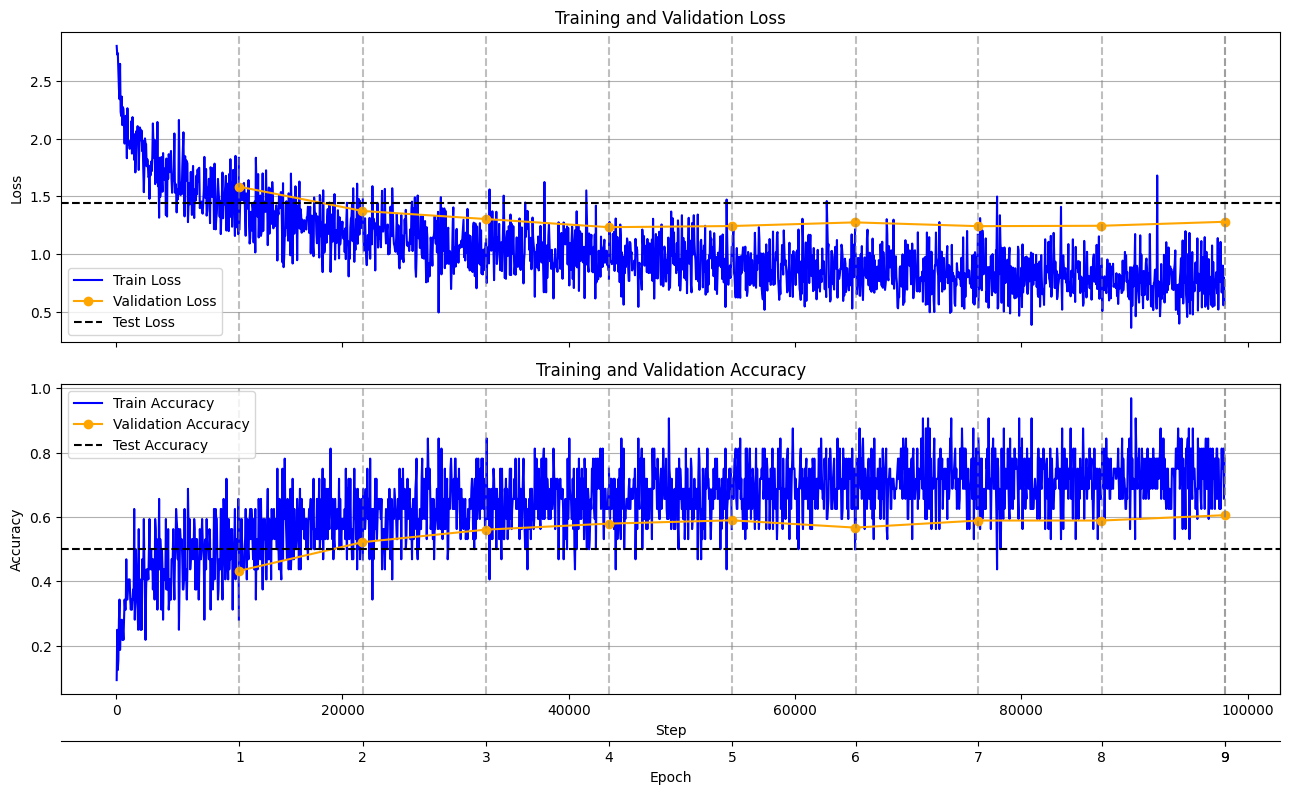

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv("lightning_logs/version_1/metrics.csv")

# Convert columns to numeric safely
df["val_loss"] = pd.to_numeric(df["val_loss"], errors='coerce')
df["val_acc"] = pd.to_numeric(df["val_acc"], errors='coerce')
df["train_loss"] = pd.to_numeric(df["train_loss"], errors='coerce')
df["train_acc"] = pd.to_numeric(df["train_acc"], errors='coerce')

# Determine where epochs end
epoch_ends = df[df["epoch"].diff().fillna(0) > 0].index.tolist()
epoch_ends.append(len(df) - 1)  # Include last row as final step

# Epoch ticks and step positions
epoch_ticks = df.loc[epoch_ends, "step"].tolist()
epoch_labels = df.loc[epoch_ends, "epoch"].astype(int).tolist()

# Optional test metrics
test_loss = df["test_loss"].dropna().iloc[-1] if "test_loss" in df.columns else None
test_acc = df["test_acc"].dropna().iloc[-1] if "test_acc" in df.columns else None

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

# Plot losses
ax1.plot(df["step"], df["train_loss"], label="Train Loss", color="blue")
ax1.plot(df["step"][df["val_loss"].notna()], df["val_loss"].dropna(), label="Validation Loss", color="orange", marker="o")

for idx in epoch_ends:
    ax1.axvline(x=df.loc[idx, "step"], color='gray', linestyle='--', alpha=0.5)

if test_loss is not None:
    ax1.axhline(y=test_loss, color='black', linestyle='--', label="Test Loss")

ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()
ax1.grid(axis='y')  # Only horizontal grid

# Plot accuracy
ax2.plot(df["step"], df["train_acc"], label="Train Accuracy", color="blue")
ax2.plot(df["step"][df["val_acc"].notna()], df["val_acc"].dropna(), label="Validation Accuracy", color="orange", marker="o")

for idx in epoch_ends:
    ax2.axvline(x=df.loc[idx, "step"], color='gray', linestyle='--', alpha=0.5)

if test_acc is not None:
    ax2.axhline(y=test_acc, color='black', linestyle='--', label="Test Accuracy")

ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Step")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
ax2.grid(axis='y')  # Only horizontal grid

# Add secondary x-axis for epochs (at bottom)
ax2_epoch = ax2.twiny()
ax2_epoch.set_frame_on(True)
ax2_epoch.patch.set_visible(False)
ax2_epoch.xaxis.set_ticks_position("bottom")
ax2_epoch.xaxis.set_label_position("bottom")
ax2_epoch.spines["bottom"].set_position(("axes", -0.15))
ax2_epoch.spines["top"].set_visible(False)
ax2_epoch.set_xlim(ax2.get_xlim())
ax2_epoch.set_xticks(epoch_ticks)
ax2_epoch.set_xticklabels(epoch_labels)
ax2_epoch.set_xlabel("Epoch")

plt.tight_layout()
plt.show()


#### Simple Encoder + MLP

##### latent = 80

In [15]:
hidden_dim = 64
latent_dim = 80
model = EncoderMLPClassifier(
    num_features=len(feature_columns),
    window_size=N,
    latent_dim=latent_dim,
    hidden_dim=hidden_dim,
    num_classes=len(label_encoder.classes_),
    lr=1e-4,
    dropout=0.2,
    weight_decay=1e-5
)

In [16]:
MAX_EPOCHS = 50
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=MAX_EPOCHS // 10,
    verbose=False,
    mode="min"
)

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[early_stop_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1
)

trainer.fit(model, train_loader, val_loader)
# Save the model
output_name = f"EMLP_h{hidden_dim}_l{latent_dim}_{now_date()}.ckpt"
trainer.save_checkpoint(os.path.join(model_output_path, output_name))

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 134 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
134 K     Trainable params
0         Non-trainable params
134 K     Total params
0.537     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 10: 100%|██████████| 10884/10884 [08:40<00:00, 20.90it/s, v_num=2, train_loss=0.548, train_acc=0.750, val_loss=0.983, val_acc=0.696]


In [17]:
model = EncoderMLPClassifier.load_from_checkpoint(os.path.join(model_output_path, output_name))
model.eval()
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1272/1272 [00:47<00:00, 27.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5754515528678894
        test_loss           1.3533320426940918
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.3533320426940918, 'test_acc': 0.5754515528678894}]

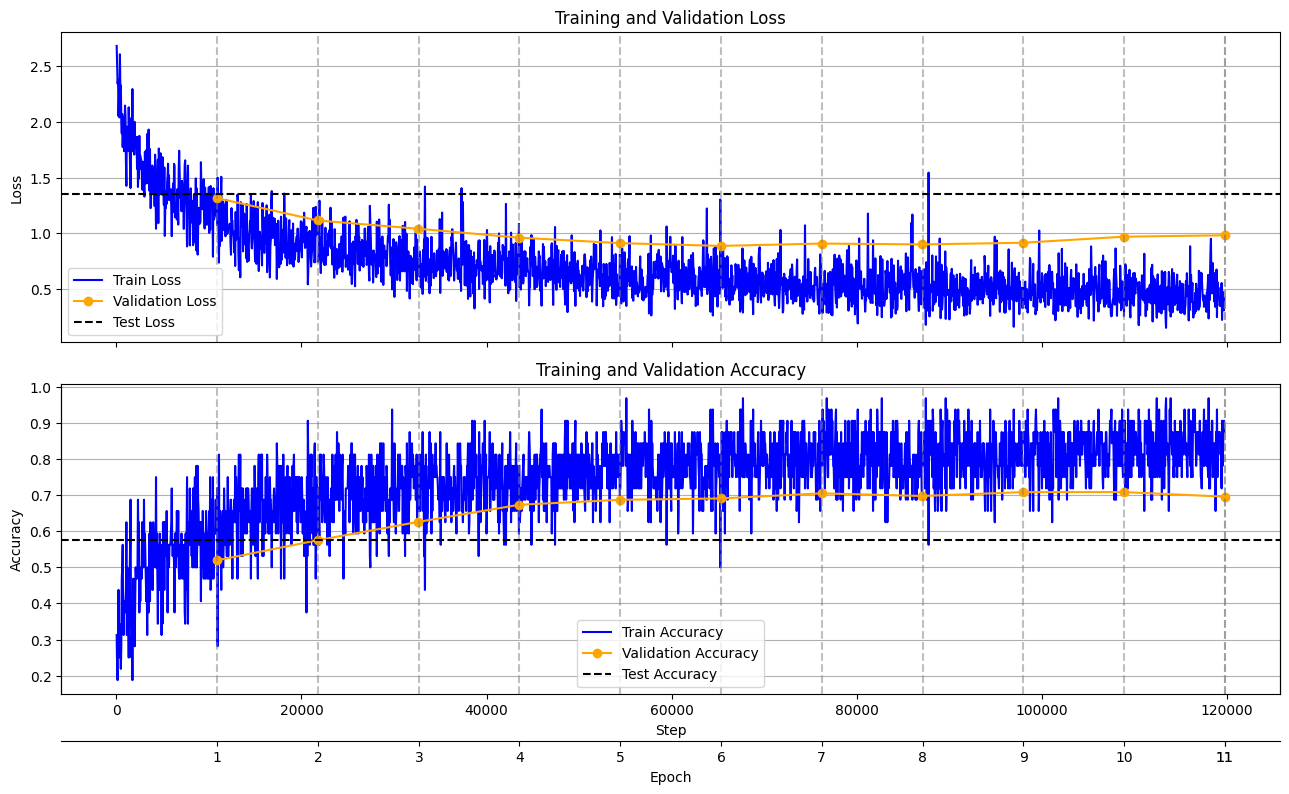

In [18]:
# Load the CSV
df = pd.read_csv("lightning_logs/version_2/metrics.csv")

# Convert columns to numeric safely
df["val_loss"] = pd.to_numeric(df["val_loss"], errors='coerce')
df["val_acc"] = pd.to_numeric(df["val_acc"], errors='coerce')
df["train_loss"] = pd.to_numeric(df["train_loss"], errors='coerce')
df["train_acc"] = pd.to_numeric(df["train_acc"], errors='coerce')

# Determine where epochs end
epoch_ends = df[df["epoch"].diff().fillna(0) > 0].index.tolist()
epoch_ends.append(len(df) - 1)  # Include last row as final step

# Epoch ticks and step positions
epoch_ticks = df.loc[epoch_ends, "step"].tolist()
epoch_labels = df.loc[epoch_ends, "epoch"].astype(int).tolist()

# Optional test metrics
test_loss = df["test_loss"].dropna().iloc[-1] if "test_loss" in df.columns else None
test_acc = df["test_acc"].dropna().iloc[-1] if "test_acc" in df.columns else None

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

# Plot losses
ax1.plot(df["step"], df["train_loss"], label="Train Loss", color="blue")
ax1.plot(df["step"][df["val_loss"].notna()], df["val_loss"].dropna(), label="Validation Loss", color="orange", marker="o")

for idx in epoch_ends:
    ax1.axvline(x=df.loc[idx, "step"], color='gray', linestyle='--', alpha=0.5)

if test_loss is not None:
    ax1.axhline(y=test_loss, color='black', linestyle='--', label="Test Loss")

ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()
ax1.grid(axis='y')  # Only horizontal grid

# Plot accuracy
ax2.plot(df["step"], df["train_acc"], label="Train Accuracy", color="blue")
ax2.plot(df["step"][df["val_acc"].notna()], df["val_acc"].dropna(), label="Validation Accuracy", color="orange", marker="o")

for idx in epoch_ends:
    ax2.axvline(x=df.loc[idx, "step"], color='gray', linestyle='--', alpha=0.5)

if test_acc is not None:
    ax2.axhline(y=test_acc, color='black', linestyle='--', label="Test Accuracy")

ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Step")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
ax2.grid(axis='y')  # Only horizontal grid

# Add secondary x-axis for epochs (at bottom)
ax2_epoch = ax2.twiny()
ax2_epoch.set_frame_on(True)
ax2_epoch.patch.set_visible(False)
ax2_epoch.xaxis.set_ticks_position("bottom")
ax2_epoch.xaxis.set_label_position("bottom")
ax2_epoch.spines["bottom"].set_position(("axes", -0.15))
ax2_epoch.spines["top"].set_visible(False)
ax2_epoch.set_xlim(ax2.get_xlim())
ax2_epoch.set_xticks(epoch_ticks)
ax2_epoch.set_xticklabels(epoch_labels)
ax2_epoch.set_xlabel("Epoch")

plt.tight_layout()
plt.show()


##### latent = 20

In [7]:
hidden_dim = 64
latent_dim = 20
model = EncoderMLPClassifier(
    num_features=len(feature_columns),
    window_size=N,
    latent_dim=latent_dim,
    hidden_dim=hidden_dim,
    num_classes=len(label_encoder.classes_),
    lr=1e-4,
    dropout=0.2,
    weight_decay=1e-5
)

In [8]:
MAX_EPOCHS = 50
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=MAX_EPOCHS // 10,
    verbose=False,
    mode="min"
)

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[early_stop_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1
)

trainer.fit(model, train_loader, val_loader)
# Save the model
output_name = f"EMLP_h{hidden_dim}_l{latent_dim}_{now_date()}.ckpt"
trainer.save_checkpoint(os.path.join(model_output_path, output_name))

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 34.5 K | train
1 | 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 29: 100%|██████████| 10884/10884 [07:58<00:00, 22.76it/s, v_num=3, train_loss=0.603, train_acc=0.812, val_loss=0.967, val_acc=0.680]


In [9]:
model = EncoderMLPClassifier.load_from_checkpoint(os.path.join(model_output_path, output_name))
model.eval()
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1272/1272 [00:41<00:00, 30.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.621083676815033
        test_loss           1.2297106981277466
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.2297106981277466, 'test_acc': 0.621083676815033}]

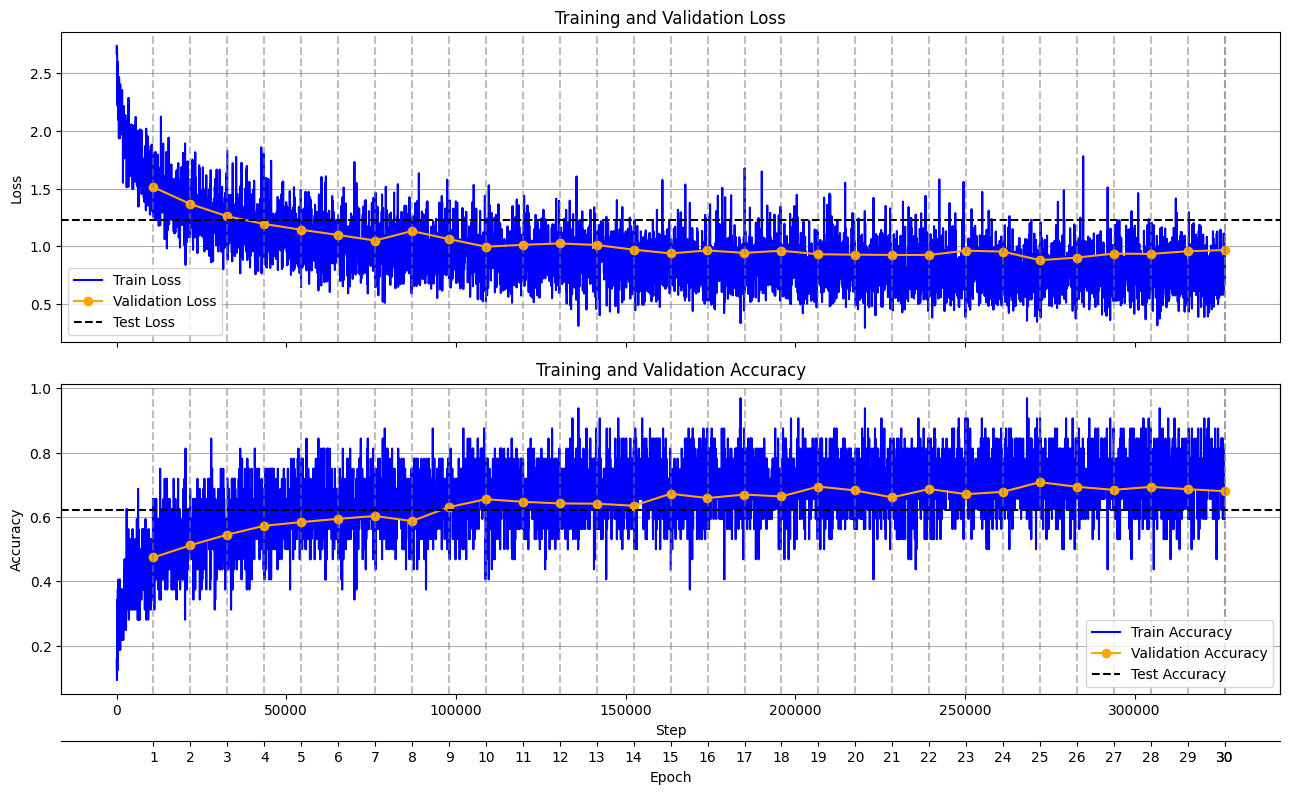

In [10]:
# Load the CSV
df = pd.read_csv("lightning_logs/version_3/metrics.csv")

# Convert columns to numeric safely
df["val_loss"] = pd.to_numeric(df["val_loss"], errors='coerce')
df["val_acc"] = pd.to_numeric(df["val_acc"], errors='coerce')
df["train_loss"] = pd.to_numeric(df["train_loss"], errors='coerce')
df["train_acc"] = pd.to_numeric(df["train_acc"], errors='coerce')

# Determine where epochs end
epoch_ends = df[df["epoch"].diff().fillna(0) > 0].index.tolist()
epoch_ends.append(len(df) - 1)  # Include last row as final step

# Epoch ticks and step positions
epoch_ticks = df.loc[epoch_ends, "step"].tolist()
epoch_labels = df.loc[epoch_ends, "epoch"].astype(int).tolist()

# Optional test metrics
test_loss = df["test_loss"].dropna().iloc[-1] if "test_loss" in df.columns else None
test_acc = df["test_acc"].dropna().iloc[-1] if "test_acc" in df.columns else None

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

# Plot losses
ax1.plot(df["step"], df["train_loss"], label="Train Loss", color="blue")
ax1.plot(df["step"][df["val_loss"].notna()], df["val_loss"].dropna(), label="Validation Loss", color="orange", marker="o")

for idx in epoch_ends:
    ax1.axvline(x=df.loc[idx, "step"], color='gray', linestyle='--', alpha=0.5)

if test_loss is not None:
    ax1.axhline(y=test_loss, color='black', linestyle='--', label="Test Loss")

ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()
ax1.grid(axis='y')  # Only horizontal grid

# Plot accuracy
ax2.plot(df["step"], df["train_acc"], label="Train Accuracy", color="blue")
ax2.plot(df["step"][df["val_acc"].notna()], df["val_acc"].dropna(), label="Validation Accuracy", color="orange", marker="o")

for idx in epoch_ends:
    ax2.axvline(x=df.loc[idx, "step"], color='gray', linestyle='--', alpha=0.5)

if test_acc is not None:
    ax2.axhline(y=test_acc, color='black', linestyle='--', label="Test Accuracy")

ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Step")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
ax2.grid(axis='y')  # Only horizontal grid

# Add secondary x-axis for epochs (at bottom)
ax2_epoch = ax2.twiny()
ax2_epoch.set_frame_on(True)
ax2_epoch.patch.set_visible(False)
ax2_epoch.xaxis.set_ticks_position("bottom")
ax2_epoch.xaxis.set_label_position("bottom")
ax2_epoch.spines["bottom"].set_position(("axes", -0.15))
ax2_epoch.spines["top"].set_visible(False)
ax2_epoch.set_xlim(ax2.get_xlim())
ax2_epoch.set_xticks(epoch_ticks)
ax2_epoch.set_xticklabels(epoch_labels)
ax2_epoch.set_xlabel("Epoch")

plt.tight_layout()
plt.show()


#### MLP

In [11]:
hidden_dim = 64
model = MLPClassifier(
    num_features=len(feature_columns),
    window_size=N,
    hidden_dim=hidden_dim,
    num_classes=len(label_encoder.classes_),
    lr=1e-4,
    dropout=0.2,
    weight_decay=1e-5
)

In [12]:
MAX_EPOCHS = 50
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=MAX_EPOCHS // 10,
    verbose=False,
    mode="min"
)

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[early_stop_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1
)

trainer.fit(model, train_loader, val_loader)
# Save the model
output_name = f"MLP_h{hidden_dim}_{now_date()}.ckpt"
trainer.save_checkpoint(os.path.join(model_output_path, output_name))

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 103 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.414     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 10884/10884 [08:15<00:00, 21.98it/s, v_num=4, train_loss=0.835, train_acc=0.719, val_loss=1.180, val_acc=0.628]


In [13]:
model = MLPClassifier.load_from_checkpoint(os.path.join(model_output_path, output_name))
model.eval()
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1272/1272 [00:41<00:00, 30.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.48170536756515503
        test_loss            1.663464903831482
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.663464903831482, 'test_acc': 0.48170536756515503}]

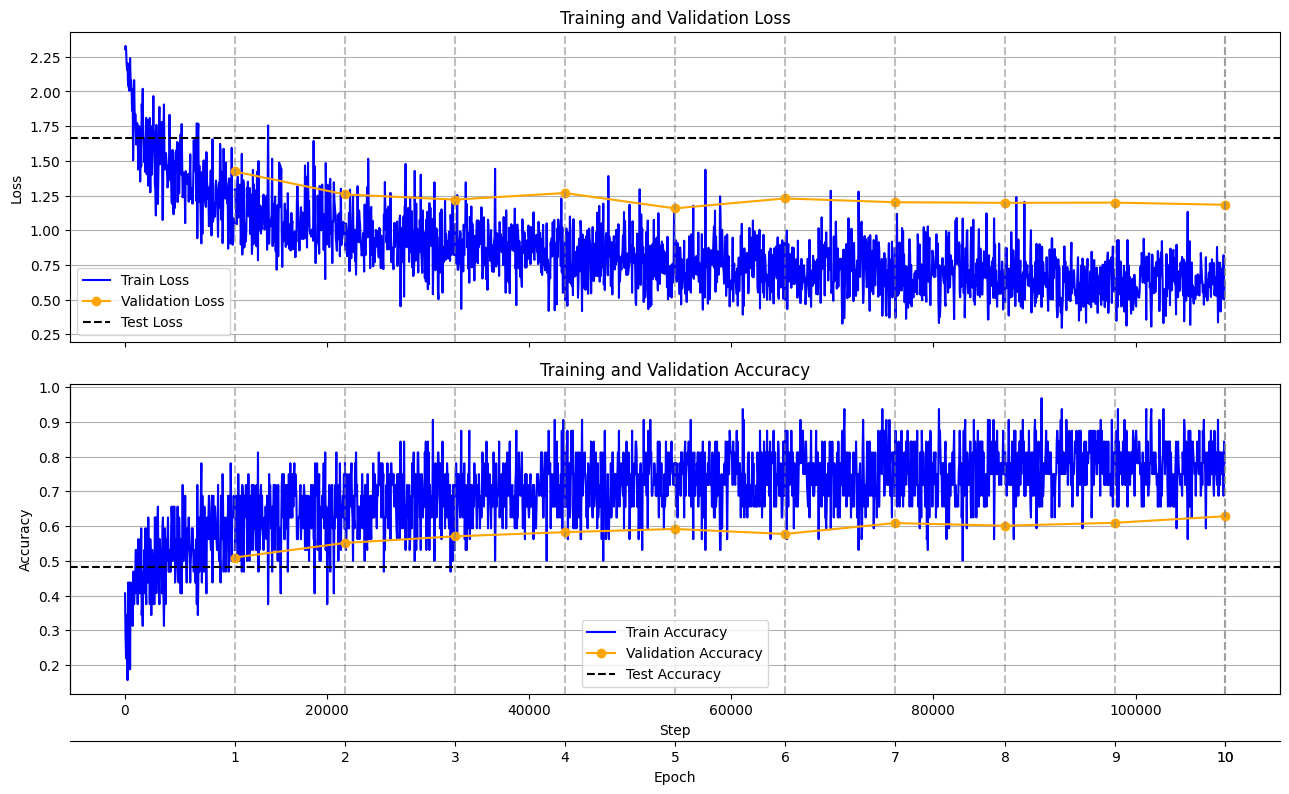

In [14]:
# Load the CSV
df = pd.read_csv("lightning_logs/version_4/metrics.csv")

# Convert columns to numeric safely
df["val_loss"] = pd.to_numeric(df["val_loss"], errors='coerce')
df["val_acc"] = pd.to_numeric(df["val_acc"], errors='coerce')
df["train_loss"] = pd.to_numeric(df["train_loss"], errors='coerce')
df["train_acc"] = pd.to_numeric(df["train_acc"], errors='coerce')

# Determine where epochs end
epoch_ends = df[df["epoch"].diff().fillna(0) > 0].index.tolist()
epoch_ends.append(len(df) - 1)  # Include last row as final step

# Epoch ticks and step positions
epoch_ticks = df.loc[epoch_ends, "step"].tolist()
epoch_labels = df.loc[epoch_ends, "epoch"].astype(int).tolist()

# Optional test metrics
test_loss = df["test_loss"].dropna().iloc[-1] if "test_loss" in df.columns else None
test_acc = df["test_acc"].dropna().iloc[-1] if "test_acc" in df.columns else None

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

# Plot losses
ax1.plot(df["step"], df["train_loss"], label="Train Loss", color="blue")
ax1.plot(df["step"][df["val_loss"].notna()], df["val_loss"].dropna(), label="Validation Loss", color="orange", marker="o")

for idx in epoch_ends:
    ax1.axvline(x=df.loc[idx, "step"], color='gray', linestyle='--', alpha=0.5)

if test_loss is not None:
    ax1.axhline(y=test_loss, color='black', linestyle='--', label="Test Loss")

ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()
ax1.grid(axis='y')  # Only horizontal grid

# Plot accuracy
ax2.plot(df["step"], df["train_acc"], label="Train Accuracy", color="blue")
ax2.plot(df["step"][df["val_acc"].notna()], df["val_acc"].dropna(), label="Validation Accuracy", color="orange", marker="o")

for idx in epoch_ends:
    ax2.axvline(x=df.loc[idx, "step"], color='gray', linestyle='--', alpha=0.5)

if test_acc is not None:
    ax2.axhline(y=test_acc, color='black', linestyle='--', label="Test Accuracy")

ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Step")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
ax2.grid(axis='y')  # Only horizontal grid

# Add secondary x-axis for epochs (at bottom)
ax2_epoch = ax2.twiny()
ax2_epoch.set_frame_on(True)
ax2_epoch.patch.set_visible(False)
ax2_epoch.xaxis.set_ticks_position("bottom")
ax2_epoch.xaxis.set_label_position("bottom")
ax2_epoch.spines["bottom"].set_position(("axes", -0.15))
ax2_epoch.spines["top"].set_visible(False)
ax2_epoch.set_xlim(ax2.get_xlim())
ax2_epoch.set_xticks(epoch_ticks)
ax2_epoch.set_xticklabels(epoch_labels)
ax2_epoch.set_xlabel("Epoch")

plt.tight_layout()
plt.show()


#### CNN 2D

In [ ]:
hidden_dim = 64
new_channels = 4
kernel_size = 2
model = CNN2DClassifier(
    num_features=len(feature_columns),
    window_size=N,
    new_channels=new_channels,
    kernel_size=kernel_size,
    hidden_dim=hidden_dim,
    num_classes=len(label_encoder.classes_),
    lr=1e-4,
    dropout=0.2,
    weight_decay=1e-5
)

In [ ]:
MAX_EPOCHS = 50
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=MAX_EPOCHS // 10,
    verbose=False,
    mode="min"
)

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[early_stop_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1
)

trainer.fit(model, train_loader, val_loader)
# Save the model
output_name = f"CNN2D_h{hidden_dim}_c{new_channels}_k{kernel_size}_{now_date()}.ckpt"
trainer.save_checkpoint(os.path.join(model_output_path, output_name))

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | cnn     | Sequential       | 20     | train
1 | fc      | Sequential       | 381 K  | train
2 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
381 K     Trainable params
0         Non-trainable params
381 K     Total params
1.525     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 7: 100%|██████████| 10884/10884 [08:41<00:00, 20.88it/s, v_num=5, train_loss=0.530, train_acc=0.875, val_loss=1.320, val_acc=0.601]


In [ ]:
# Load the model for testing (from checkpoint)
model = CNN2DClassifier.load_from_checkpoint(os.path.join(model_output_path, output_name))
model.eval()
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1272/1272 [00:42<00:00, 29.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5487406253814697
        test_loss            1.776224970817566
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.776224970817566, 'test_acc': 0.5487406253814697}]

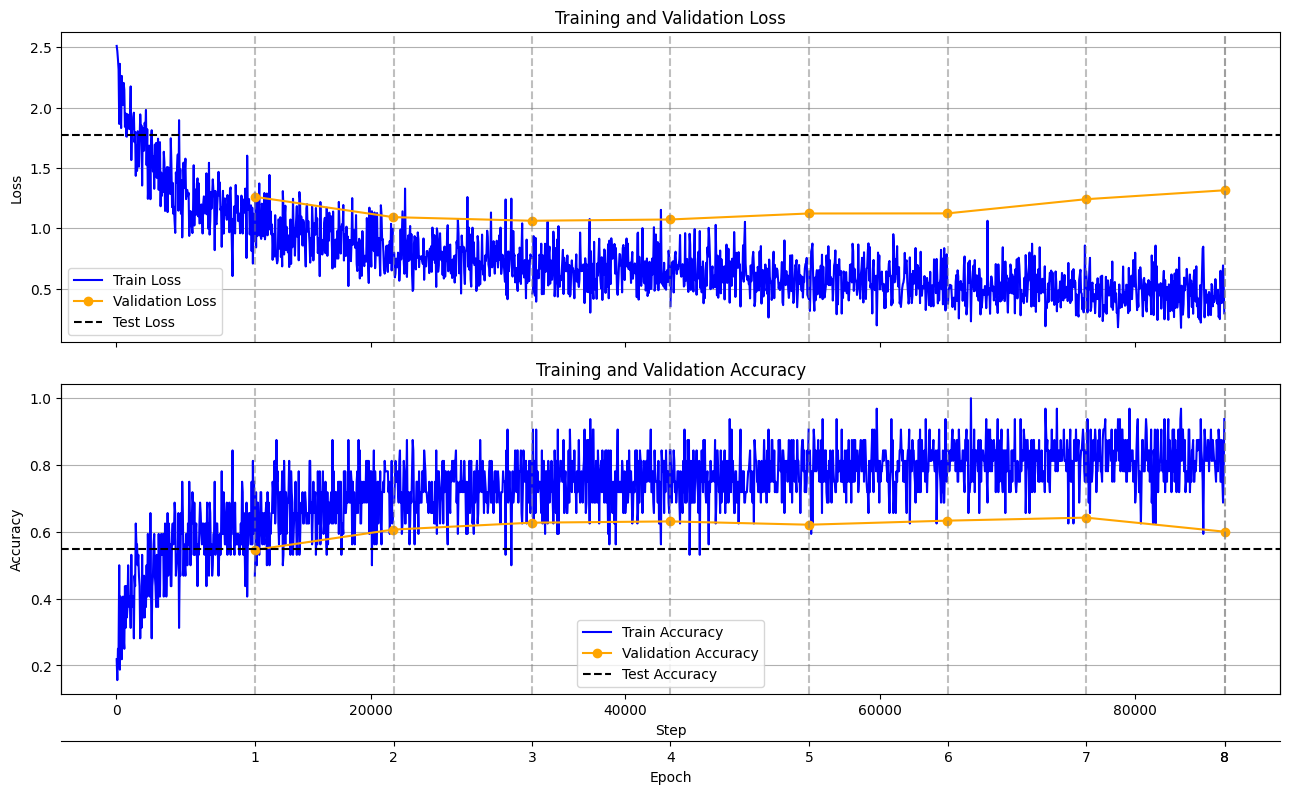

In [19]:
# Load the CSV
df = pd.read_csv("lightning_logs/version_5/metrics.csv")

# Convert columns to numeric safely
df["val_loss"] = pd.to_numeric(df["val_loss"], errors='coerce')
df["val_acc"] = pd.to_numeric(df["val_acc"], errors='coerce')
df["train_loss"] = pd.to_numeric(df["train_loss"], errors='coerce')
df["train_acc"] = pd.to_numeric(df["train_acc"], errors='coerce')

# Determine where epochs end
epoch_ends = df[df["epoch"].diff().fillna(0) > 0].index.tolist()
epoch_ends.append(len(df) - 1)  # Include last row as final step

# Epoch ticks and step positions
epoch_ticks = df.loc[epoch_ends, "step"].tolist()
epoch_labels = df.loc[epoch_ends, "epoch"].astype(int).tolist()

# Optional test metrics
test_loss = df["test_loss"].dropna().iloc[-1] if "test_loss" in df.columns else None
test_acc = df["test_acc"].dropna().iloc[-1] if "test_acc" in df.columns else None

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

# Plot losses
ax1.plot(df["step"], df["train_loss"], label="Train Loss", color="blue")
ax1.plot(df["step"][df["val_loss"].notna()], df["val_loss"].dropna(), label="Validation Loss", color="orange", marker="o")

for idx in epoch_ends:
    ax1.axvline(x=df.loc[idx, "step"], color='gray', linestyle='--', alpha=0.5)

if test_loss is not None:
    ax1.axhline(y=test_loss, color='black', linestyle='--', label="Test Loss")

ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()
ax1.grid(axis='y')  # Only horizontal grid

# Plot accuracy
ax2.plot(df["step"], df["train_acc"], label="Train Accuracy", color="blue")
ax2.plot(df["step"][df["val_acc"].notna()], df["val_acc"].dropna(), label="Validation Accuracy", color="orange", marker="o")

for idx in epoch_ends:
    ax2.axvline(x=df.loc[idx, "step"], color='gray', linestyle='--', alpha=0.5)

if test_acc is not None:
    ax2.axhline(y=test_acc, color='black', linestyle='--', label="Test Accuracy")

ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Step")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
ax2.grid(axis='y')  # Only horizontal grid

# Add secondary x-axis for epochs (at bottom)
ax2_epoch = ax2.twiny()
ax2_epoch.set_frame_on(True)
ax2_epoch.patch.set_visible(False)
ax2_epoch.xaxis.set_ticks_position("bottom")
ax2_epoch.xaxis.set_label_position("bottom")
ax2_epoch.spines["bottom"].set_position(("axes", -0.15))
ax2_epoch.spines["top"].set_visible(False)
ax2_epoch.set_xlim(ax2.get_xlim())
ax2_epoch.set_xticks(epoch_ticks)
ax2_epoch.set_xticklabels(epoch_labels)
ax2_epoch.set_xlabel("Epoch")

plt.tight_layout()
plt.show()


#### CNN 1D

In [8]:
hidden_dim = 64
new_channels = 4
kernel_size = 3
model = CNN1DClassifier(
    num_features=len(feature_columns),
    window_size=N,
    out_channels=new_channels,
    kernel_size=kernel_size,
    hidden_dim=hidden_dim,
    num_classes=len(label_encoder.classes_),
    lr=1e-4,
    dropout=0.2,
    weight_decay=1e-5
)

In [9]:
MAX_EPOCHS = 50
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=MAX_EPOCHS // 10,
    verbose=False,
    mode="min"
)

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[early_stop_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1
)

trainer.fit(model, train_loader, val_loader)
# Save the model
output_name = f"CNN1D_h{hidden_dim}_c{new_channels}_k{kernel_size}_{now_date()}.ckpt"
trainer.save_checkpoint(os.path.join(model_output_path, output_name))

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | cnn     | Sequential       | 196    | train
1 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 39: 100%|██████████| 10884/10884 [09:49<00:00, 18.47it/s, v_num=14, train_loss=0.851, train_acc=0.656, val_loss=1.290, val_acc=0.562]


In [10]:
# Load the model for testing (from checkpoint)
model = CNN1DClassifier.load_from_checkpoint(os.path.join(model_output_path, output_name))
model.eval()
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1272/1272 [00:50<00:00, 25.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4400540590286255
        test_loss           1.6783883571624756
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.6783883571624756, 'test_acc': 0.4400540590286255}]

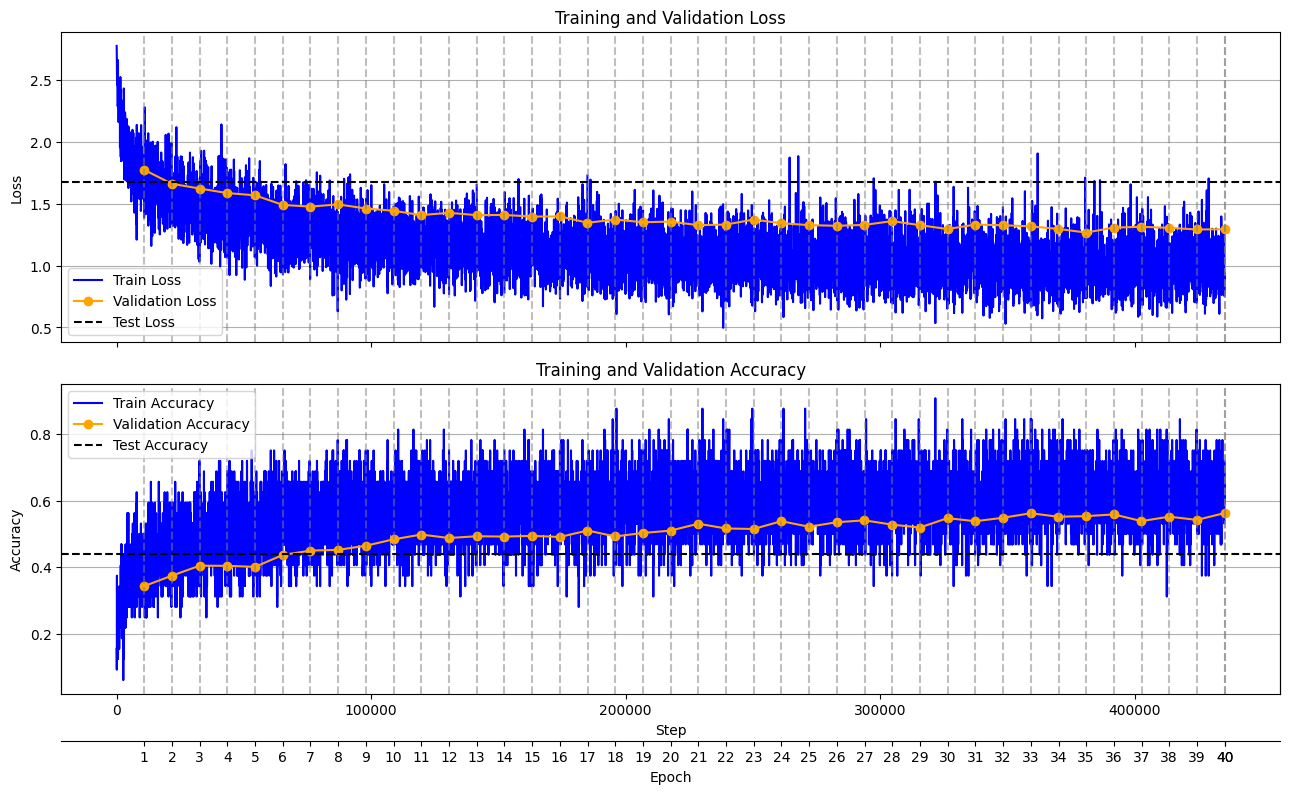

In [11]:
# Load the CSV
df = pd.read_csv("lightning_logs/version_14/metrics.csv")

# Convert columns to numeric safely
df["val_loss"] = pd.to_numeric(df["val_loss"], errors='coerce')
df["val_acc"] = pd.to_numeric(df["val_acc"], errors='coerce')
df["train_loss"] = pd.to_numeric(df["train_loss"], errors='coerce')
df["train_acc"] = pd.to_numeric(df["train_acc"], errors='coerce')

# Determine where epochs end
epoch_ends = df[df["epoch"].diff().fillna(0) > 0].index.tolist()
epoch_ends.append(len(df) - 1)  # Include last row as final step

# Epoch ticks and step positions
epoch_ticks = df.loc[epoch_ends, "step"].tolist()
epoch_labels = df.loc[epoch_ends, "epoch"].astype(int).tolist()

# Optional test metrics
test_loss = df["test_loss"].dropna().iloc[-1] if "test_loss" in df.columns else None
test_acc = df["test_acc"].dropna().iloc[-1] if "test_acc" in df.columns else None

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

# Plot losses
ax1.plot(df["step"], df["train_loss"], label="Train Loss", color="blue")
ax1.plot(df["step"][df["val_loss"].notna()], df["val_loss"].dropna(), label="Validation Loss", color="orange", marker="o")

for idx in epoch_ends:
    ax1.axvline(x=df.loc[idx, "step"], color='gray', linestyle='--', alpha=0.5)

if test_loss is not None:
    ax1.axhline(y=test_loss, color='black', linestyle='--', label="Test Loss")

ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()
ax1.grid(axis='y')  # Only horizontal grid

# Plot accuracy
ax2.plot(df["step"], df["train_acc"], label="Train Accuracy", color="blue")
ax2.plot(df["step"][df["val_acc"].notna()], df["val_acc"].dropna(), label="Validation Accuracy", color="orange", marker="o")

for idx in epoch_ends:
    ax2.axvline(x=df.loc[idx, "step"], color='gray', linestyle='--', alpha=0.5)

if test_acc is not None:
    ax2.axhline(y=test_acc, color='black', linestyle='--', label="Test Accuracy")

ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Step")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
ax2.grid(axis='y')  # Only horizontal grid

# Add secondary x-axis for epochs (at bottom)
ax2_epoch = ax2.twiny()
ax2_epoch.set_frame_on(True)
ax2_epoch.patch.set_visible(False)
ax2_epoch.xaxis.set_ticks_position("bottom")
ax2_epoch.xaxis.set_label_position("bottom")
ax2_epoch.spines["bottom"].set_position(("axes", -0.15))
ax2_epoch.spines["top"].set_visible(False)
ax2_epoch.set_xlim(ax2.get_xlim())
ax2_epoch.set_xticks(epoch_ticks)
ax2_epoch.set_xticklabels(epoch_labels)
ax2_epoch.set_xlabel("Epoch")

plt.tight_layout()
plt.show()


#### RNN

In [6]:
# Parametri modello
hidden_dim = 64
rnn_type = "GRU"

model = RNNClassifier(
    input_dim=len(feature_columns),
    hidden_dim=hidden_dim,
    output_dim=len(label_encoder.classes_),
    rnn_type=rnn_type,
    lr=1e-4,
    dropout=0.2,
    weight_decay=1e-5
)

In [7]:
# Training setup
MAX_EPOCHS = 50

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=MAX_EPOCHS // 10,
    verbose=False,
    mode="min"
)

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[early_stop_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    log_every_n_steps=10
)

# Addestramento
trainer.fit(model, train_loader, val_loader)

# Salvataggio modello
output_name = f"RNN_{rnn_type}_h{hidden_dim}_{now_date()}.ckpt"
trainer.save_checkpoint(os.path.join(model_output_path, output_name))

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | rnn     | GRU              | 15.7 K | train
1 | 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 1:   0%|          | 2/10884 [00:00<10:54, 16.62it/s, v_num=13, train_loss=1.330, train_acc=0.531, val_loss=1.580, val_acc=0.456]    

c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 18. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 8: 100%|██████████| 10884/10884 [10:43<00:00, 16.91it/s, v_num=13, train_loss=0.554, train_acc=0.781, val_loss=1.400, val_acc=0.579]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 10884/10884 [07:19<00:00, 24.75it/s]

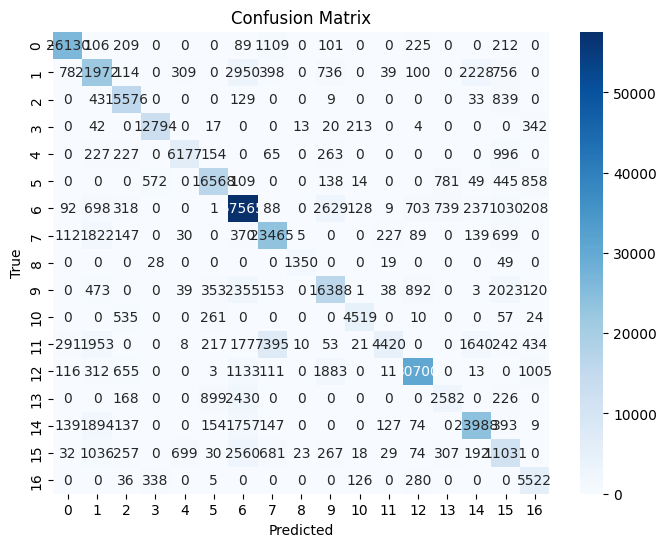

Testing DataLoader 0: 100%|██████████| 10884/10884 [07:20<00:00, 24.69it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     final_test_acc         0.8060771822929382
        test_acc            0.8060771822929382
        test_loss           0.5511807203292847
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████| 1348/1348 [00:54<00:00, 24.94it/s]

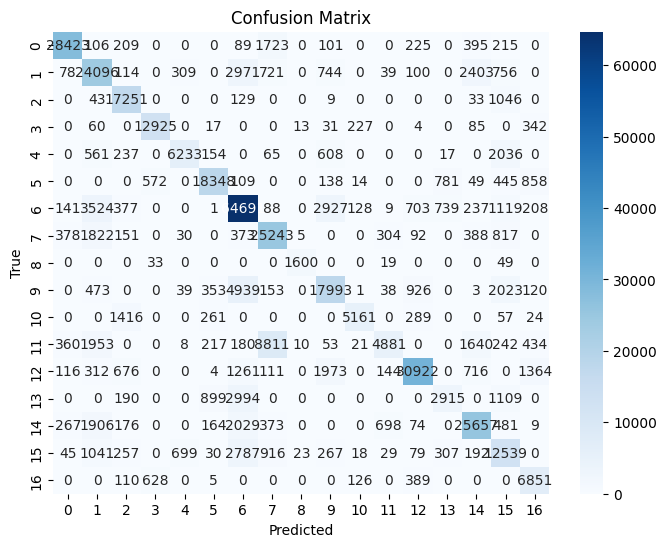

Testing DataLoader 0: 100%|██████████| 1348/1348 [00:55<00:00, 24.39it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     final_test_acc         0.7810965776443481
        test_acc            0.5793330669403076
        test_loss           1.3967547416687012
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████| 1272/1272 [00:51<00:00, 24.79it/s]

c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 23. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


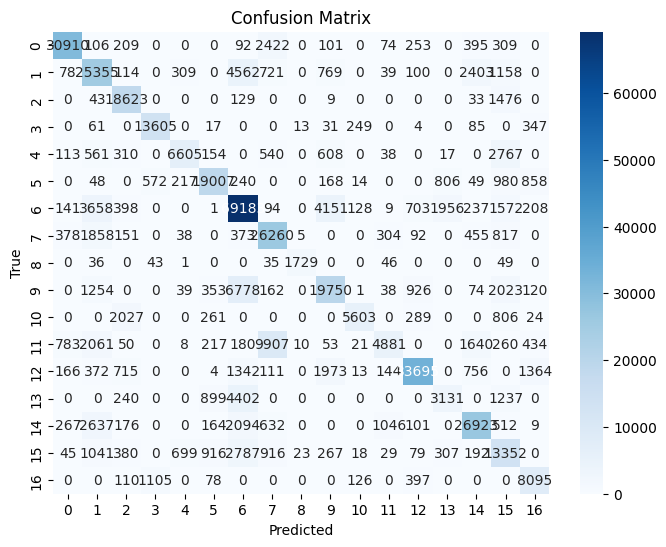

Testing DataLoader 0: 100%|██████████| 1272/1272 [00:52<00:00, 24.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     final_test_acc         0.7560824155807495
        test_acc            0.5154933333396912
        test_loss            1.51873779296875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.51873779296875,
  'test_acc': 0.5154933333396912,
  'final_test_acc': 0.7560824155807495}]

In [8]:
# Load the model for testing (from checkpoint)
model = RNNClassifier.load_from_checkpoint(os.path.join(model_output_path, output_name))
model.eval()
trainer.test(model, train_loader)
trainer.test(model, val_loader)
trainer.test(model, test_loader)

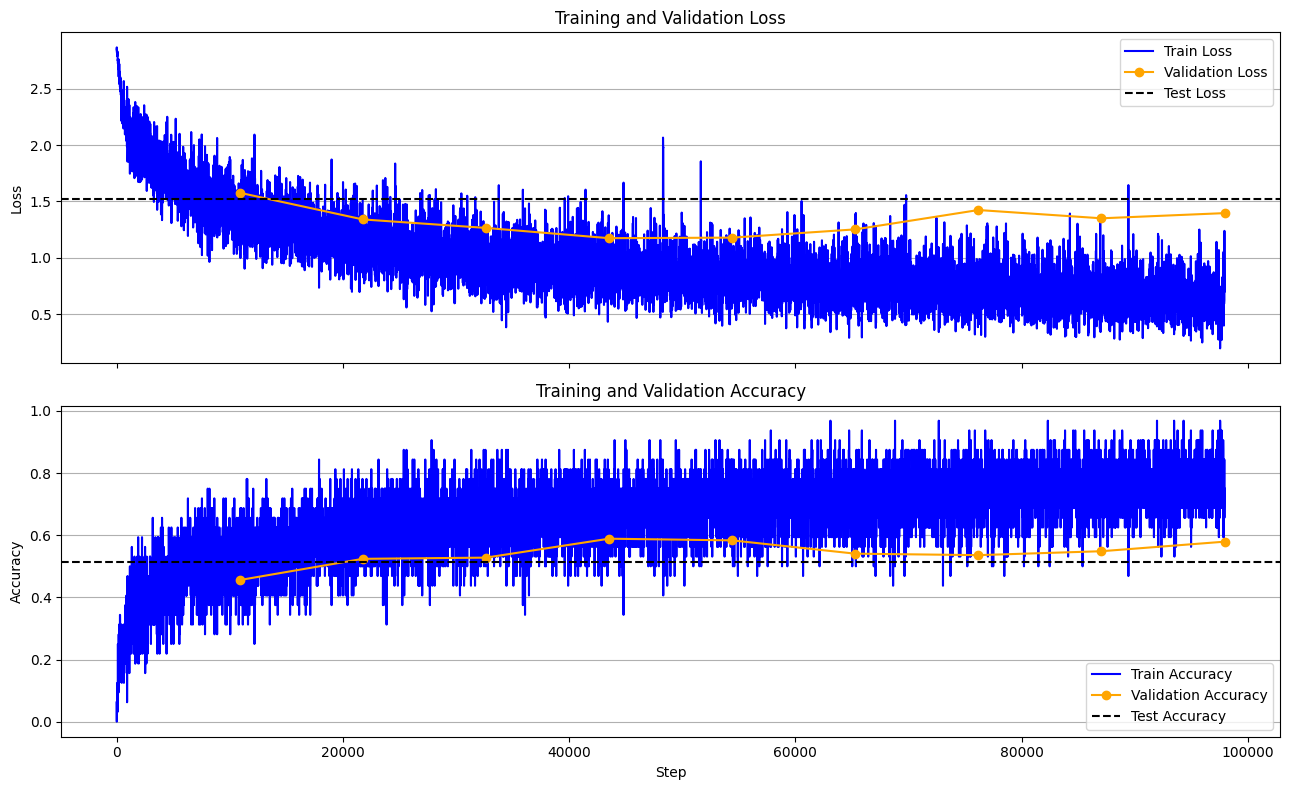

In [9]:
# Load the CSV
df = pd.read_csv("lightning_logs/version_13/metrics.csv")

# Convert columns to numeric safely
df["val_loss"] = pd.to_numeric(df["val_loss"], errors='coerce')
df["val_acc"] = pd.to_numeric(df["val_acc"], errors='coerce')
df["train_loss"] = pd.to_numeric(df["train_loss"], errors='coerce')
df["train_acc"] = pd.to_numeric(df["train_acc"], errors='coerce')


# Optional test metrics
test_loss = df["test_loss"].dropna().iloc[-1] if "test_loss" in df.columns else None
test_acc = df["test_acc"].dropna().iloc[-1] if "test_acc" in df.columns else None

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

# Plot losses
ax1.plot(df["step"], df["train_loss"], label="Train Loss", color="blue")
ax1.plot(df["step"][df["val_loss"].notna()], df["val_loss"].dropna(), label="Validation Loss", color="orange", marker="o")


if test_loss is not None:
    ax1.axhline(y=test_loss, color='black', linestyle='--', label="Test Loss")

ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()
ax1.grid(axis='y')  # Only horizontal grid

# Plot accuracy
ax2.plot(df["step"], df["train_acc"], label="Train Accuracy", color="blue")
ax2.plot(df["step"][df["val_acc"].notna()], df["val_acc"].dropna(), label="Validation Accuracy", color="orange", marker="o")

if test_acc is not None:
    ax2.axhline(y=test_acc, color='black', linestyle='--', label="Test Accuracy")

ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Step")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
ax2.grid(axis='y')  # Only horizontal grid

plt.tight_layout()
plt.show()
